# Using Random Forest to Measure Conditional Entropy

For reasoning behind such an algorithm read here: https://www.overleaf.com/read/hjdnbwbrnbvt

We will first construct a dataset that we can hand calculate conditional entropy for.

In [96]:
x = [0]*5 + [1]*6 + [2]*5 + [3]*6
y = [0]*11 + [1]*11
x_test = [0]*2 + [1]*3 + [2]*2 + [3]*3
y_test = [0]*5 + [1]*5
x, y

([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

H(X) = 1.38215  
H(Y) = .69314  
H(Y, X) = 1.38215  
H(Y|X) = 0  
I(X, Y) = .69314  

Note that this case is very trivial. If random forest can correctly spearate when Y = 1 and when Y = 0, then each parition will always have only one unique element (either y = 1 or y = 0), so entropy should equal 0.

## Algorithm implementation

In [20]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree


In [27]:
# 1 run random forest
model = RandomForestClassifier(n_estimators = 2, max_depth = 2, random_state = 0)
X = np.array(x).reshape(-1, 1)
y = np.array(y)
X_test = np.array(x_test).reshape(-1, 1)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [75]:
# now store leaf counts
tree_entropies = []
n_trees = 0
for tree_in_forest in model:
    n_trees += 1
    unique, counts = np.unique(tree_in_forest.apply(X), return_counts = True)
    n = counts.sum()
    # get count of number of elements in each leaf partition
    binCount = dict(zip(unique, counts))
    # get probabilities
    probs = tree_in_forest.predict_proba(X_test)
    # get entropies in each leaf
    entropies = np.nan_to_num(-np.sum(np.log(probs)*probs, axis = 1))
    # get leaf assignment in order to pair up with leaf count
    leaf_counts = np.vectorize(binCount.get)(tree_in_forest.apply(X_test))
    tree_entropies.append(entropies*leaf_counts)
cond_entropies = sum(tree_entropies)
average_conditional_entropy = np.sum(cond_entropies) / len(cond_entropies)
average_conditional_entropy

/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


0.0

Cleanedup algorithm   
TODO: Probably a faster way of doing the above with more numpy stuff

In [91]:
# have it so it splits training for you
from sklearn.model_selection import train_test_split
#TODO: clean up code better
#TODO: modularize and other stuff

def estimate_conditional_entropy(X, y, n_trees, max_depth):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = RandomForestClassifier(n_estimators =n_trees, max_depth = max_depth, random_state = 0)
    model.fit(X_train, y_train)
    tree_entropies = []
    x_counts = []
    n_trees = 0
    for tree_in_forest in model:
        n_trees += 1
        unique, counts = np.unique(tree_in_forest.apply(X), return_counts = True)
        n = counts.sum()
        # get count of number of elements in each leaf partition
        binCount = dict(zip(unique, counts))
        # get probabilities
        probs = tree_in_forest.predict_proba(X_test)
        # get entropies in each leaf
        entropies = np.nan_to_num(-np.sum(np.log(probs)*probs, axis = 1))
        # get leaf assignment in order to pair up with leaf count
        leaf_counts = np.vectorize(binCount.get)(tree_in_forest.apply(X_test))
        x_counts.append(leaf_counts)
        tree_entropies.append(entropies*leaf_counts)
    cond_entropies = sum(tree_entropies) / sum(x_counts)
    # take average
    return np.sum(cond_entropies) / len(cond_entropies)
    

Let's try on slightly harder data (not clearly dependent)

In [83]:
x = [0]*20 + [1]*20 + [2]*20 + [3]*20
y = [0, 1, 0, 1, 0]*4 + [ 1, 1, 1, 1, 0]*4 + [1, 0, 1, 0, 1]*4 + [0, 0, 0, 0, 1]*4
X = np.array(x).reshape(-1, 1)
y = np.array(y)

Hand calculations  
H(X) = 1.386294  
H(Y) = 0.693147  
H(X, Y) = 1.97300  
H(Y|X) = .5867  

In [92]:
estimate_conditional_entropy(X, y, 10, 4)

0.5741372126070781

For completeness, let's try completely independent dataset.

In [94]:
x = [0, 1]*40
y = [0]*40 + [1]*40
X = np.array(x).reshape(-1, 1)
y = np.array(y)

H(X) = 0.6931471805599453  
H(Y) = 0.6931451805599453  
H(X, Y) = 1.3862943611198906  
H(Y|X) = 0.6931451805599453  

In [95]:
estimate_conditional_entropy(X, y, 10, 4)

0.6723345286587842

## Test on iris dataset

In [106]:
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()
# take first 2 features
X = iris.data[:100, :2]
# take first 100 (only two classes)
y = iris.target[:100]

In [107]:
X.shape

(100, 2)

Text(0.5,1,'Iris Dataset Scatter Plot')

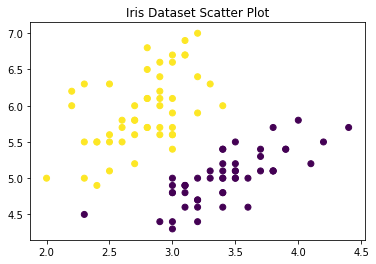

In [109]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1], X[:, 0], c = y)
plt.title('Iris Dataset Scatter Plot')

In [118]:
import scipy

def calculate_entropy(X):
    probs = np.bincount(X)/len(X)
    return scipy.stats.entropy(probs)

calculate_entropy(y)
print("Conditional Entropy", estimate_conditional_entropy(X, y, 10, 4))

Conditional Entropy 0.004285278281264995


/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/usr/local/Cellar/jupyter/1.0.0_5/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
